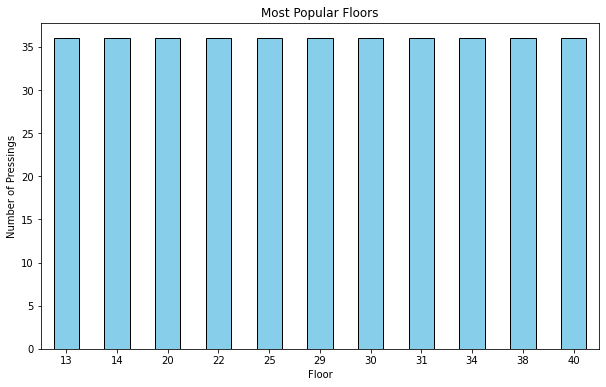

     uid  arrival_time   enter_time  waiting_time  assigned_elevator
0      0    377.322585   377.322585      0.000000                  0
1      2    407.985533   407.985533      0.000000                  0
2      7    176.203680   176.203680      0.000000                  0
3     13    377.357003   377.357003      0.000000                  0
4     20    500.224714   500.224714      0.000000                  0
..   ...           ...          ...           ...                ...
391  320   1361.025443  1407.660000     46.634557                  7
392  326   1849.033026  1849.033026      0.000000                  7
393  335   2027.610404  2027.610404      0.000000                  7
394  352   1904.726245  1904.726245      0.000000                  7
395  377   2950.618951  2950.618951      0.000000                  7

[396 rows x 5 columns]


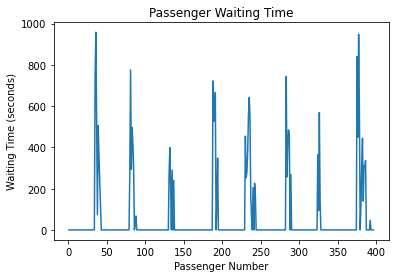

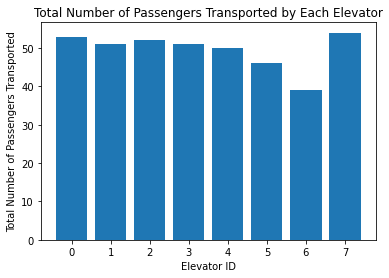

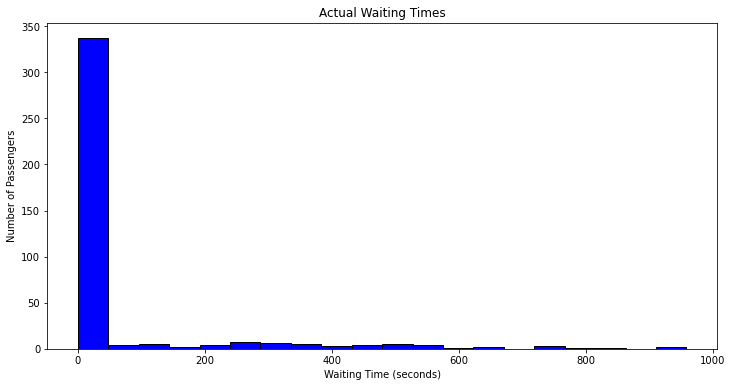

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load passengers data from CSV
passengers_df = pd.read_csv('simulation.csv')

# Plot the most popular floors
floor_counts = passengers_df['origin_floor'].value_counts()
plt.figure(figsize=(10, 6))
floor_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Floor')
plt.ylabel('Number of Pressings')
plt.title('Most Popular Floors')
plt.xticks(rotation=0)
plt.show()

# Define the Elevator class
class Elevator:
    def __init__(self, elevator_id):
        self.elevator_id = elevator_id
        self.current_load = 0
        self.passengers_transported = 0
        self.travel_time = 0
        self.current_floor = 1  # Assuming all elevators start at the lobby
        self.available_time = 0  # Time when the elevator will be available

# Define the Elevator Dispatching Problem with robust control
class ElevatorDispatchingProblemRobust:
    def __init__(self, floors, elevators, capacity):
        self.floors = floors
        self.elevators = elevators
        self.capacity = capacity
        self.acceleration_time = 2  # seconds
        self.deceleration_time = 2  # seconds
        self.constant_speed = 10  # m/s
        self.stop_time = 3  # seconds
        self.floor_height = 2.6  # meters per floor (assumed for calculation)
    
    def calculate_travel_time(self, origin_floor, destination_floor):
        distance = abs(destination_floor - origin_floor) * self.floor_height
        travel_time = (2 * self.acceleration_time + distance / self.constant_speed + self.stop_time)
        return travel_time
    
    def assign_transportation_requests(self, passengers):
        """Binary assignment of transportation requests to elevators"""
        assignments = {}
        for passenger in passengers:
            elevator = np.random.choice(self.elevators)  # Randomly assign an elevator for simplicity
            if elevator.elevator_id not in assignments:
                assignments[elevator.elevator_id] = []
            assignments[elevator.elevator_id].append(passenger)
        return assignments
    
    def optimal_control(self, elevator, requests):
        """Solve the optimal control problem for an elevator's trip"""
        control_sequence = []
        state = {
            'passengers': 0,
            'time': elevator.available_time
        }
        for request in requests:
            if state['passengers'] < self.capacity:
                state['passengers'] += 1
                travel_time = self.calculate_travel_time(elevator.current_floor, request['origin_floor'])
                state['time'] += travel_time + self.stop_time
                control_sequence.append({
                    'stop_floor': request['origin_floor'],
                    'arrival_time': state['time']
                })
                elevator.current_floor = request['origin_floor']
                elevator.passengers_transported += 1  # Update passengers transported
            # Handle the delivery request (going to the lobby in this case)
            travel_time = self.calculate_travel_time(elevator.current_floor, 1)
            state['time'] += travel_time + self.stop_time
            control_sequence.append({
                'stop_floor': 1,
                'arrival_time': state['time']
            })
            elevator.current_floor = 1
            state['passengers'] = 0
        elevator.available_time = state['time']  # Update the available time of the elevator
        return control_sequence

    def assign_elevators(self, passengers):
        # Pre-assign elevators to the most popular floors
        popular_floors = floor_counts.index[:8].tolist()
        for i, elevator in enumerate(self.elevators):
            if i < len(popular_floors):
                elevator.current_floor = popular_floors[i]
        
        # Simulate elevator assignments and solve the optimal control problem for each elevator
        assignments = self.assign_transportation_requests(passengers)
        waiting_times = []
        passenger_log = []

        for elevator in self.elevators:
            if elevator.elevator_id in assignments:
                control_sequence = self.optimal_control(elevator, assignments[elevator.elevator_id])
                for request in assignments[elevator.elevator_id]:
                    arrival_time = request['arrival_time']
                    stop_time = next((stop['arrival_time'] for stop in control_sequence if stop['stop_floor'] == request['origin_floor']), None)
                    if stop_time is not None:
                        wait_time = stop_time - arrival_time
                        wait_time = max(0, wait_time)  # Ensure waiting time is not negative
                        waiting_times.append(wait_time)
                        passenger_log.append({
                            'uid': request['uid'],
                            'arrival_time': arrival_time,
                            'enter_time': arrival_time + wait_time,
                            'waiting_time': wait_time,
                            'assigned_elevator': elevator.elevator_id
                        })

        return assignments, waiting_times, passenger_log

# Initialize elevators to serve all floors
elevators = [Elevator(i) for i in range(8)]  # 8 elevators

# Convert passenger data to dictionary records
passengers = passengers_df.to_dict(orient='records')

# Instantiate the elevator dispatching problem with robust control
edp_robust = ElevatorDispatchingProblemRobust(floors=40, elevators=elevators, capacity=30)

# Assign elevators to passengers
assignments, waiting_times, passenger_log = edp_robust.assign_elevators(passengers)

# Convert passenger_log to DataFrame
passenger_log_df = pd.DataFrame(passenger_log)

# Print the passenger log
print(passenger_log_df)

# Plot Passenger Number vs Actual Travel Time
plt.figure()
plt.plot(range(1, len(passengers) + 1), [p['waiting_time'] for p in passenger_log])
plt.xlabel('Passenger Number')
plt.ylabel('Waiting Time (seconds)')
plt.title('Passenger Waiting Time')
plt.show()

# Plot Total Number of Passengers Transported by Each Elevator
elevator_ids = range(8)
plt.figure()
plt.bar(elevator_ids, [elevator.passengers_transported for elevator in elevators])
plt.xlabel('Elevator ID')
plt.ylabel('Total Number of Passengers Transported')
plt.title('Total Number of Passengers Transported by Each Elevator')
plt.show()

# Plot Waiting Time Histogram
plt.figure(figsize=(12, 6))
plt.hist([p['waiting_time'] for p in passenger_log], bins=20, color='b', edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Number of Passengers')
plt.title('Actual Waiting Times')
plt.show()


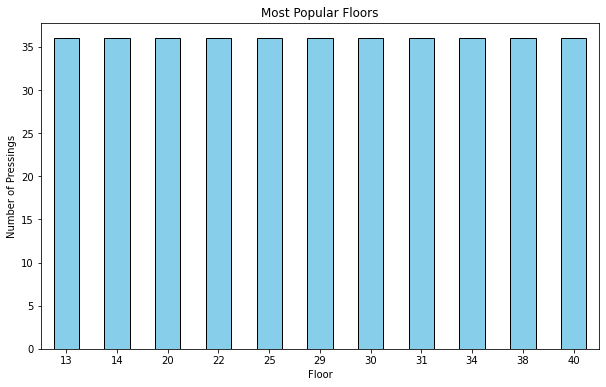

     uid  arrival_time   enter_time  waiting_time  assigned_elevator
0     11    270.888320   270.888320           0.0                  0
1     15    476.235737   476.235737           0.0                  0
2     29    554.623190   554.623190           0.0                  0
3     31    425.950585   425.950585           0.0                  0
4     38    724.519936   724.519936           0.0                  0
..   ...           ...          ...           ...                ...
391  302   1467.412037  1467.412037           0.0                  7
392  307   1673.966702  1673.966702           0.0                  7
393  317   1766.281588  1766.281588           0.0                  7
394  327   2319.536994  2319.536994           0.0                  7
395  356   2271.796568  2271.796568           0.0                  7

[396 rows x 5 columns]


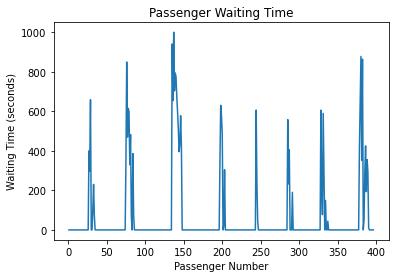

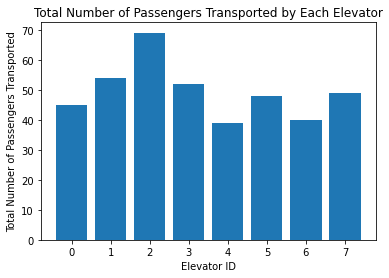

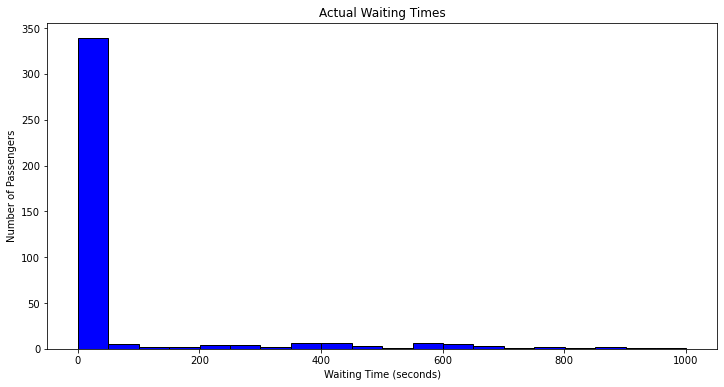

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load passengers data from CSV
passengers_df = pd.read_csv('simulation.csv')

# Plot the most popular floors
floor_counts = passengers_df['origin_floor'].value_counts()
plt.figure(figsize=(10, 6))
floor_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Floor')
plt.ylabel('Number of Pressings')
plt.title('Most Popular Floors')
plt.xticks(rotation=0)
plt.show()

# Define the Elevator class
class Elevator:
    def __init__(self, elevator_id):
        self.elevator_id = elevator_id
        self.current_load = 0
        self.passengers_transported = 0
        self.travel_time = 0
        self.current_floor = 1  # Assuming all elevators start at the lobby
        self.available_time = 0  # Time when the elevator will be available

# Define the Elevator Dispatching Problem with robust control
class ElevatorDispatchingProblemRobust:
    def __init__(self, floors, elevators, capacity):
        self.floors = floors
        self.elevators = elevators
        self.capacity = capacity
        self.acceleration_time = 2  # seconds
        self.deceleration_time = 2  # seconds
        self.constant_speed = 10  # m/s
        self.stop_time = 3  # seconds
        self.floor_height = 2.6  # meters per floor (assumed for calculation)
    
    def calculate_travel_time(self, origin_floor, destination_floor):
        distance = abs(destination_floor - origin_floor) * self.floor_height
        travel_time = (2 * self.acceleration_time + distance / self.constant_speed + self.stop_time)
        return travel_time
    
    def assign_transportation_requests(self, passengers):
        """Binary assignment of transportation requests to elevators"""
        assignments = {}
        for passenger in passengers:
            elevator = np.random.choice(self.elevators)  # Randomly assign an elevator for simplicity
            if elevator.elevator_id not in assignments:
                assignments[elevator.elevator_id] = []
            assignments[elevator.elevator_id].append(passenger)
        return assignments
    
    def optimal_control(self, elevator, requests):
        """Solve the optimal control problem for an elevator's trip"""
        control_sequence = []
        state = {
            'passengers': 0,
            'time': elevator.available_time
        }
        for request in requests:
            if state['passengers'] < self.capacity:
                state['passengers'] += 1
                travel_time = self.calculate_travel_time(elevator.current_floor, request['origin_floor'])
                state['time'] += travel_time + self.stop_time
                control_sequence.append({
                    'stop_floor': request['origin_floor'],
                    'arrival_time': state['time']
                })
                elevator.current_floor = request['origin_floor']
                elevator.passengers_transported += 1  # Update passengers transported
            # Handle the delivery request (going to the lobby in this case)
            travel_time = self.calculate_travel_time(elevator.current_floor, 1)
            state['time'] += travel_time + self.stop_time
            control_sequence.append({
                'stop_floor': 1,
                'arrival_time': state['time']
            })
            elevator.current_floor = 1
            state['passengers'] = 0
        elevator.available_time = state['time']  # Update the available time of the elevator
        return control_sequence

    def assign_elevators(self, passengers):
        # Simulate elevator assignments and solve the optimal control problem for each elevator
        assignments = self.assign_transportation_requests(passengers)
        waiting_times = []
        passenger_log = []

        for elevator in self.elevators:
            if elevator.elevator_id in assignments:
                control_sequence = self.optimal_control(elevator, assignments[elevator.elevator_id])
                for request in assignments[elevator.elevator_id]:
                    arrival_time = request['arrival_time']
                    stop_time = next((stop['arrival_time'] for stop in control_sequence if stop['stop_floor'] == request['origin_floor']), None)
                    if stop_time is not None:
                        wait_time = stop_time - arrival_time
                        wait_time = max(0, wait_time)  # Ensure waiting time is not negative
                        waiting_times.append(wait_time)
                        passenger_log.append({
                            'uid': request['uid'],
                            'arrival_time': arrival_time,
                            'enter_time': arrival_time + wait_time,
                            'waiting_time': wait_time,
                            'assigned_elevator': elevator.elevator_id
                        })

        return assignments, waiting_times, passenger_log

# Initialize elevators to serve all floors
elevators = [Elevator(i) for i in range(8)]  # 8 elevators

# Convert passenger data to dictionary records
passengers = passengers_df.to_dict(orient='records')

# Instantiate the elevator dispatching problem with robust control
edp_robust = ElevatorDispatchingProblemRobust(floors=40, elevators=elevators, capacity=30)

# Assign elevators to passengers
assignments, waiting_times, passenger_log = edp_robust.assign_elevators(passengers)

# Convert passenger_log to DataFrame
passenger_log_df = pd.DataFrame(passenger_log)

# Print the passenger log
print(passenger_log_df)

# Plot Passenger Number vs Actual Travel Time
plt.figure()
plt.plot(range(1, len(passengers) + 1), [p['waiting_time'] for p in passenger_log])
plt.xlabel('Passenger Number')
plt.ylabel('Waiting Time (seconds)')
plt.title('Passenger Waiting Time')
plt.show()

# Plot Total Number of Passengers Transported by Each Elevator
elevator_ids = range(8)
plt.figure()
plt.bar(elevator_ids, [elevator.passengers_transported for elevator in elevators])
plt.xlabel('Elevator ID')
plt.ylabel('Total Number of Passengers Transported')
plt.title('Total Number of Passengers Transported by Each Elevator')
plt.show()

# Plot Waiting Time Histogram
plt.figure(figsize=(12, 6))
plt.hist([p['waiting_time'] for p in passenger_log], bins=20, color='b', edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Number of Passengers')
plt.title('Actual Waiting Times')
plt.show()


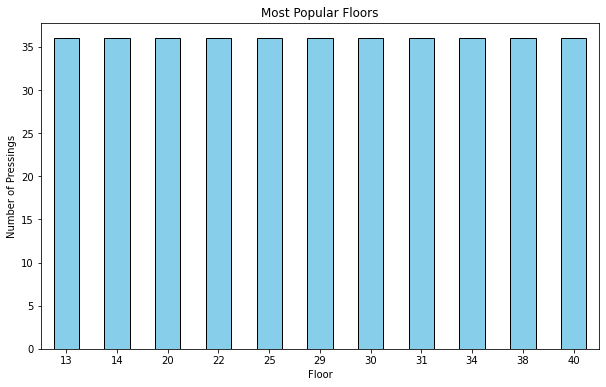

     uid  arrival_time  enter_time  waiting_time  assigned_elevator
0      0    377.322585          63   -314.322585                  0
1      1    368.265204          63   -305.265204                  1
2      2    407.985533          63   -344.985533                  2
3      3    292.760333          63   -229.760333                  3
4      4    133.276092          63    -70.276092                  4
..   ...           ...         ...           ...                ...
391  391   2674.490556       11460   8785.509444                  6
392  392   2701.638529       11476   8774.361471                  5
393  393   2634.573727       11506   8871.426273                  3
394  394   2897.993279       11564   8666.006721                  1
395  395   2910.082301       11609   8698.917699                  2

[396 rows x 5 columns]


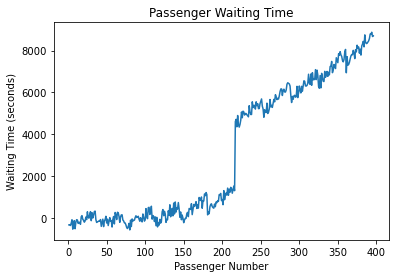

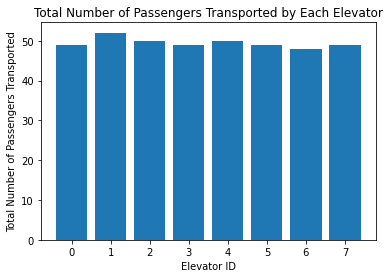

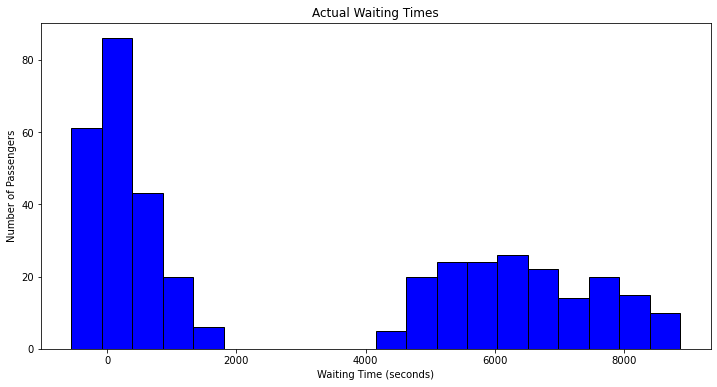

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load passengers data from CSV
passengers_df = pd.read_csv('simulation.csv')

# Plot the most popular floors
floor_counts = passengers_df['origin_floor'].value_counts()
plt.figure(figsize=(10, 6))
floor_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Floor')
plt.ylabel('Number of Pressings')
plt.title('Most Popular Floors')
plt.xticks(rotation=0)
plt.show()

# Define the Elevator class
class Elevator:
    def __init__(self, elevator_id):
        self.elevator_id = elevator_id
        self.current_load = 0
        self.passengers_transported = 0
        self.travel_time = 0
        self.current_floor = 1  # Assuming all elevators start at the lobby
        self.available_time = 0  # Time when the elevator will be available

    def move_to_floor(self, destination_floor):
        # Simulate moving to the destination floor and updating the available time
        travel_time = abs(destination_floor - self.current_floor) * 5  # Assume 5 seconds per floor
        self.travel_time += travel_time
        self.available_time += travel_time + 3  # 3 seconds for stopping time
        self.current_floor = destination_floor

    def load_passenger(self, passenger):
        self.passengers_transported += 1
        self.current_load += 1

    def unload_passenger(self):
        self.current_load -= 1

# Define the FCFS Elevator Dispatching Algorithm
class FCFS_ElevatorDispatching:
    def __init__(self, elevators):
        self.elevators = elevators

    def assign_elevator(self, passenger):
        # Find the next available elevator (earliest available time)
        next_elevator = min(self.elevators, key=lambda e: e.available_time)
        return next_elevator

    def process_requests(self, passengers):
        waiting_times = []
        passenger_log = []

        for passenger in passengers:
            # Assign the next available elevator
            elevator = self.assign_elevator(passenger)
            arrival_time = passenger['arrival_time']

            # Move elevator to the passenger's origin floor
            if elevator.current_floor != passenger['origin_floor']:
                elevator.move_to_floor(passenger['origin_floor'])

            # Load the passenger
            elevator.load_passenger(passenger)
            enter_time = elevator.available_time
            waiting_time = enter_time - arrival_time
            waiting_times.append(waiting_time)
            passenger_log.append({
                'uid': passenger['uid'],
                'arrival_time': arrival_time,
                'enter_time': enter_time,
                'waiting_time': waiting_time,
                'assigned_elevator': elevator.elevator_id
            })

            # Move elevator to the destination floor and unload the passenger
            elevator.move_to_floor(passenger['destination_floor'])
            elevator.unload_passenger()

        return waiting_times, passenger_log

# Initialize elevators
elevators = [Elevator(i) for i in range(8)]  # 8 elevators

# Convert passenger data to dictionary records
passengers = passengers_df.to_dict(orient='records')

# Instantiate the FCFS elevator dispatching algorithm
fcfs_edp = FCFS_ElevatorDispatching(elevators)

# Process the passenger requests
waiting_times, passenger_log = fcfs_edp.process_requests(passengers)

# Convert passenger_log to DataFrame
passenger_log_df = pd.DataFrame(passenger_log)

# Print the passenger log
print(passenger_log_df)

# Plot Passenger Number vs Actual Travel Time
plt.figure()
plt.plot(range(1, len(passengers) + 1), [p['waiting_time'] for p in passenger_log])
plt.xlabel('Passenger Number')
plt.ylabel('Waiting Time (seconds)')
plt.title('Passenger Waiting Time')
plt.show()

# Plot Total Number of Passengers Transported by Each Elevator
elevator_ids = range(8)
plt.figure()
plt.bar(elevator_ids, [elevator.passengers_transported for elevator in elevators])
plt.xlabel('Elevator ID')
plt.ylabel('Total Number of Passengers Transported')
plt.title('Total Number of Passengers Transported by Each Elevator')
plt.show()

# Plot Waiting Time Histogram
plt.figure(figsize=(12, 6))
plt.hist([p['waiting_time'] for p in passenger_log], bins=20, color='b', edgecolor='black')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Number of Passengers')
plt.title('Actual Waiting Times')
plt.show()
